In [1]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras import regularizers

2023-12-12 01:42:43.732460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Model Data 
Checkpoint: Load cached data here

In [2]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [3]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [4]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df
# train_df = pd.concat([train_white_df, train_black_df, train_asian_df])

### DEFINE MODEL AND PREPARE DATA

In [5]:
# Prepare Model Data --> [takes 2 min.]
pca = PCA(n_components=25) 
prognosis_names = encoded_df.label.unique()

def get_x_y(df): 
    x = np.array([pca.fit_transform(np.transpose(data)) for data in df.sample_data.values]) # shrink to 26 values
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df)) # training data

x_train_black, y_train_black = get_x_y(train_black_df)
x_train_asian, y_train_asian = get_x_y(train_asian_df)

x_test_white, y_test_white = get_x_y(test_white_df)
x_test_black, y_test_black = get_x_y(test_black_df)
x_test_asian, y_test_asian = get_x_y(test_asian_df)

In [6]:
# DEFINE MODEL

# Creating an LSTM model 
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])))  # Adjust the units as needed
model.add(Dense(23, activation='softmax'))  # Output layer with 23 classes and softmax activation

# Freeze Model Function 
def freeze_model(model): 
    model.trainable = False 
    model.layers[-1].trainable = True
    return model 


### Model Results for Freezing Last Layer

In [7]:
### RESULTS FOR BLACK / AA Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=25, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/10
19/19 [==============================] - 3s 47ms/step - loss: 3.0614 - accuracy: 0.1213 - val_loss: 2.0858 - val_accuracy: 0.5981
Epoch 2/10
19/19 [==============================] - 0s 12ms/step - loss: 1.5766 - accuracy: 0.6678 - val_loss: 1.1970 - val_accuracy: 0.6822
Epoch 3/10
19/19 [==============================] - 0s 12ms/step - loss: 1.1839 - accuracy: 0.6611 - val_loss: 1.0869 - val_accuracy: 0.6822
Epoch 4/10
19/19 [==============================] - 0s 12ms/step - loss: 1.1082 - accuracy: 0.6611 - val_loss: 1.0609 - val_accuracy: 0.6822
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - loss: 1.0635 - accuracy: 0.6678 - val_loss: 1.0470 - val_accuracy: 0.6822
Epoch 6/10
19/19 [==============================] - 0s 14ms/step - loss: 1.0332 - accuracy: 0.6811 - val_loss: 1.0460 - val_accuracy: 0.6822
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 1.0028 - accura

In [8]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 6ms/step - loss: 1.0132 - accuracy: 0.8205
Performance on Black Patients
----------------------------------
Loss on test data: 1.013234257698059
Accuracy on test data: 0.8205128312110901


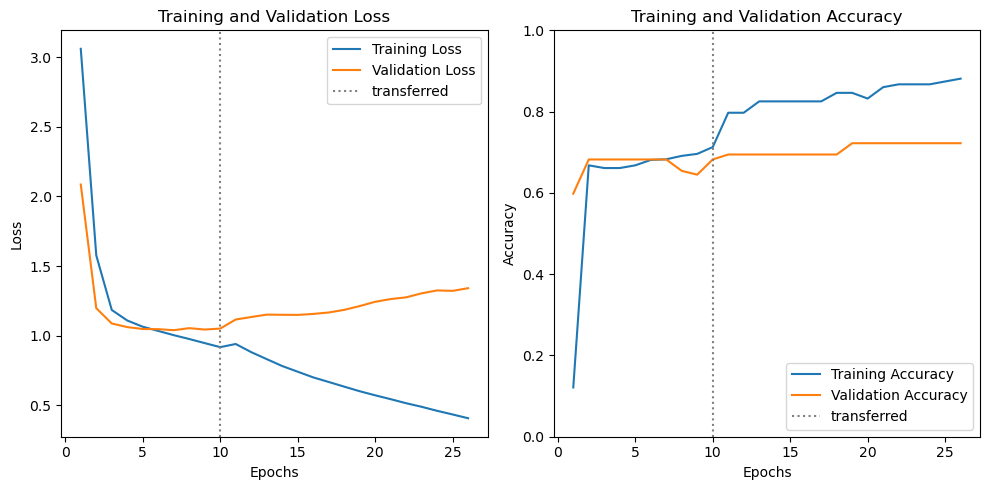

In [9]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
### RESULTS FOR Asian Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO ASAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=25, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/10
19/19 [==============================] - 4s 48ms/step - loss: 1.0691 - accuracy: 0.6645 - val_loss: 1.0948 - val_accuracy: 0.6636
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.9221 - accuracy: 0.7193 - val_loss: 1.0666 - val_accuracy: 0.6636
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 0.8615 - accuracy: 0.7342 - val_loss: 1.0756 - val_accuracy: 0.6542
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.8200 - accuracy: 0.7492 - val_loss: 1.0885 - val_accuracy: 0.6636
Epoch 5/10
19/19 [==============================] - 0s 16ms/step - loss: 0.7926 - accuracy: 0.7425 - val_loss: 1.1010 - val_accuracy: 0.6262
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.7506 - accuracy: 0.7724 - val_loss: 1.1138 - val_accuracy: 0.6168
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.7183 - accura

In [11]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 34ms/step - loss: 0.7856 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 0.7855626344680786
Accuracy on test data: 0.8214285969734192


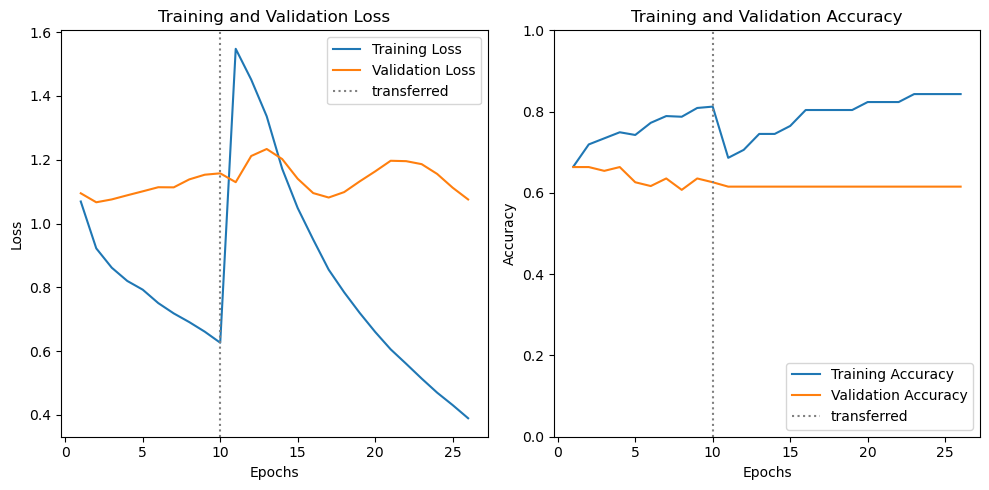

In [12]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Model Results for just Fine Tuning

In [13]:
### RESULTS FOR BLACK / AA Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=25, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/10
19/19 [==============================] - 3s 46ms/step - loss: 0.8294 - accuracy: 0.7492 - val_loss: 1.2081 - val_accuracy: 0.5981
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.6424 - accuracy: 0.8073 - val_loss: 1.1913 - val_accuracy: 0.6168
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 0.5859 - accuracy: 0.8140 - val_loss: 1.2527 - val_accuracy: 0.6262
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.5629 - accuracy: 0.8256 - val_loss: 1.2176 - val_accuracy: 0.6168
Epoch 5/10
19/19 [==============================] - 0s 12ms/step - loss: 0.5214 - accuracy: 0.8389 - val_loss: 1.2352 - val_accuracy: 0.6075
Epoch 6/10
19/19 [==============================] - 0s 14ms/step - loss: 0.4969 - accuracy: 0.8422 - val_loss: 1.2571 - val_accuracy: 0.6168
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.4686 - accura

In [14]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 5ms/step - loss: 1.1882 - accuracy: 0.7949
Performance on Black Patients
----------------------------------
Loss on test data: 1.1881685256958008
Accuracy on test data: 0.7948718070983887


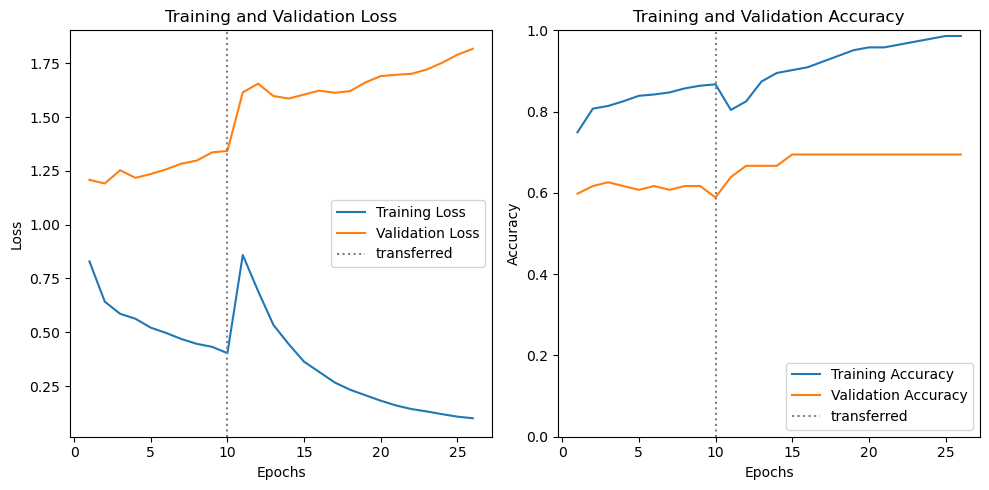

In [15]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
### RESULTS FOR Asian Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))


# Transfer Learning 
print("---------------------- TRANSFER TO ASAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=25, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/10
19/19 [==============================] - 3s 48ms/step - loss: 0.6510 - accuracy: 0.7724 - val_loss: 1.3946 - val_accuracy: 0.5794
Epoch 2/10
19/19 [==============================] - 0s 14ms/step - loss: 0.4430 - accuracy: 0.8571 - val_loss: 1.4016 - val_accuracy: 0.5794
Epoch 3/10
19/19 [==============================] - 0s 13ms/step - loss: 0.3799 - accuracy: 0.8821 - val_loss: 1.4279 - val_accuracy: 0.6075
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.3464 - accuracy: 0.8920 - val_loss: 1.4542 - val_accuracy: 0.5888
Epoch 5/10
19/19 [==============================] - 0s 13ms/step - loss: 0.3291 - accuracy: 0.9020 - val_loss: 1.4504 - val_accuracy: 0.6262
Epoch 6/10
19/19 [==============================] - 0s 13ms/step - loss: 0.3142 - accuracy: 0.9020 - val_loss: 1.5124 - val_accuracy: 0.5981
Epoch 7/10
19/19 [==============================] - 0s 13ms/step - loss: 0.2863 - accura

In [17]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 34ms/step - loss: 1.1075 - accuracy: 0.7857
Performance on Asian Patients
----------------------------------
Loss on test data: 1.107520341873169
Accuracy on test data: 0.7857142686843872


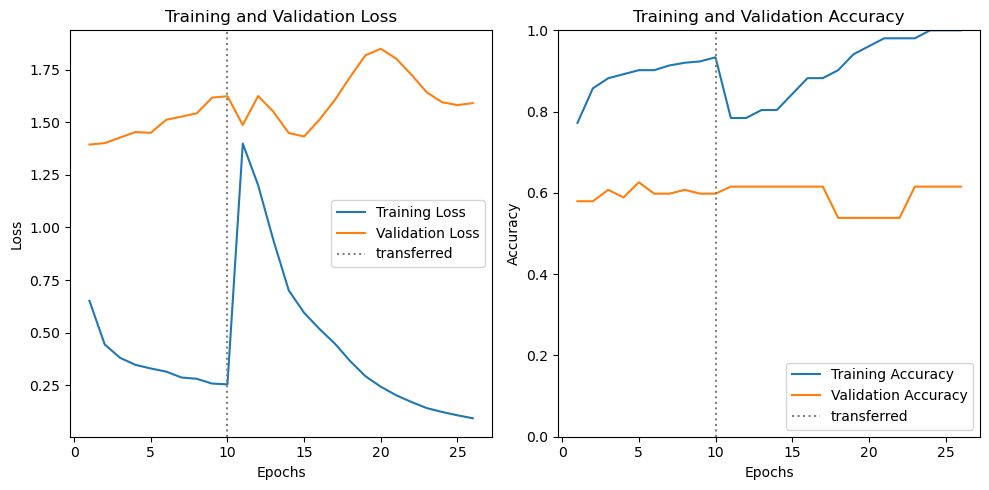

In [18]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 10, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()